In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from scipy.spatial.transform import Rotation as R
import copy
from ipywidgets import interactive

Populating the interactive namespace from numpy and matplotlib


In [2]:
class h2omol:
    """h2o molecule"""    
    
    def __init__(self,bond1=2.75,bond2=2.75,theta1=0,theta2=0):
        self.bond1=bond1
        self.bond2=bond2
        self.theta1=theta1
        self.theta2=theta2
        OHlen=0.95
        self.oloc=array([0.,0.,0.])
        self.h1 = array([1., 0., -1./sqrt(2)] /sqrt(3/2)*OHlen)
        self.h2 = array([-1., 0., -1./sqrt(2)]/sqrt(3/2)*OHlen)
        self.t1 = array([1, 0., -1./sqrt(2)] /sqrt(3/2)*OHlen)
        self.t2 = array([-1, 0., -1./sqrt(2)]/sqrt(3/2)*OHlen)
        self.t3 = array([0., -1., 1./sqrt(2)] /sqrt(3/2)*OHlen)
        self.t4 = array([0., 1., 1./sqrt(2)]  /sqrt(3/2)*OHlen)
        self.setHBonds(bond1,bond2,theta1,theta2)
    
    def shift(self,vec):
        vec=array(vec)
        self.oloc=self.oloc+vec
        self.h1=self.h1+vec
        self.h2=self.h2+vec
        self.t1=self.t1+vec
        self.t2=self.t2+vec
        self.t3=self.t3+vec
        self.t4=self.t4+vec
        
    def setHBonds(self,bond1=2.75,bond2=2.75,theta1=0,theta2=0):
        
        rotax=np.cross(self.h1, self.h2)
        rotax=rotax/norm(rotax)
        
        Rot=R.from_rotvec(theta1*rotax)
        v=array(self.h1)-array(self.oloc)
        v=Rot.apply(v)         #rotate bond
        v=v/norm(v)*bond1+array(self.oloc)
        self.h1=v
        
        Rot=R.from_rotvec(theta2*rotax)
        v=array(self.h2)-array(self.oloc)
        v=Rot.apply(v)         #rotate bond
        v=v/norm(v)*bond2+array(self.oloc)
        self.h2=v


    def rotate(self,axsis,angle):
        rotax=axsis/norm(axsis)
        Rot=R.from_rotvec(angle*rotax)
        self.oloc=Rot.apply(self.oloc)
        self.h1=Rot.apply(self.h1)
        self.h2=Rot.apply(self.h2)
        self.t1=Rot.apply(self.t1)
        self.t2=Rot.apply(self.t2)
        self.t3=Rot.apply(self.t3)
        self.t4=Rot.apply(self.t4)
        
    def alignaxsis(self,vecfromparent,iialignaxsis):
        if(iialignaxsis==3):
            alignaxsis=self.t3
        elif(iialignaxsis==4):
            alignaxsis=self.t4
        elif(iialignaxsis==1):
            alignaxsis=self.h1
        elif(iialignaxsis==2):
            alignaxsis=self.h2
        else:
            print("error")
            return (-1)
        orignitmp=array(self.oloc)
        self.shift(-orignitmp)
        
        a,b=-vecfromparent,alignaxsis
        v=np.cross(a,b)
        v=v/norm(v)
        angle=arccos(a.dot(b)/(norm(a)*norm(b)))
        self.rotate(v,-angle)
        self.shift(orignitmp)

    
    
    def plotmol(self,ax):
        #central molecule tethra.
        x, y, z = transpose([y for x in combinations([self.t1,self.t2,self.t3,self.t4], 2) for y in x])
        ax.plot(x, y, z)

        ax.scatter(self.oloc[0], self.oloc[1], self.oloc[2], color="r", s=100)
        ax.scatter(self.t1[0], self.t1[1], self.t1[2], color="b", s=50)
        ax.scatter(self.t2[0], self.t2[1], self.t2[2], color="b", s=50)
        
        x, y, z = zip(self.oloc,self.h1)
        ax.plot(x, y, z, "r:")
        x, y, z = zip(self.oloc,self.h2)
        ax.plot(x, y, z, "g:")


def getHgbh(h2molCent,ii,jj):    
    # add molecule on parent H-bond
    h2mol1=h2omol(bond1=h2molCent.bond1,bond2=h2molCent.bond2,theta1=h2molCent.theta1,theta2=h2molCent.theta2)
    c1=h2molCent.oloc
    h2molCent.shift(-c1)
    c2=h2mol1.oloc
    h2mol1.shift(-c2)
    
    if(ii==1):
        a=h2molCent.h1
    if(ii==2):
        a=h2molCent.h2
    h2mol1.alignaxsis(a,jj )
    #random rotate
    h2mol1.rotate(a,2*pi*random_sample())
    
    h2mol1.shift(a)
    h2molCent.shift(c1)
    h2mol1.shift(c1)
    return h2mol1

        
def getNHgbh(h2molCent,ii,jj):    
    # add molecule on non-H-bond
    h2mol3=h2omol(bond1=h2molCent.bond1,bond2=h2molCent.bond2,theta1=h2molCent.theta1,theta2=h2molCent.theta2)
    c1=h2molCent.oloc
    h2molCent.shift(-c1)
    
    if(ii==3):
        a=h2molCent.t3
        a=a/norm(a)*h2mol3.bond2
    if(ii==4):
        a=h2molCent.t4
        a=a/norm(a)*h2mol3.bond1
        
    h2mol3.alignaxsis(a,jj)
    h2mol3.rotate(a,2*pi*random_sample())
    
    h2mol3.shift(a)
    h2mol3.shift(c1)
    
    h2molCent.shift(c1)
    return h2mol3
    
    


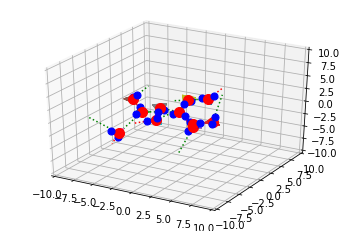

In [3]:
def fcluster(bond1,bond2,theta1,theta2,getcluster=False):
    cluster=[]
    h2molCent=h2omol(bond1=bond1,bond2=bond2,theta1=deg2rad(theta1),theta2=deg2rad(theta2))
#     h2molCent.shift([-1,1,0.5]) 
    
    h2mol1=getHgbh(h2molCent,1,4)
    h2mol2=getHgbh(h2molCent,2,4)

    h2mol11=getHgbh(h2mol1,1,4)
    h2mol12=getHgbh(h2mol1,2,4)

    h2mol21=getHgbh(h2mol2,1,4)
    h2mol22=getHgbh(h2mol2,2,4)

    ##################
    h2mol3=getNHgbh(h2molCent,3,2)
    h2mol4=getNHgbh(h2molCent,4,1)
    
    h2mol31=getHgbh(h2mol3,1,4)
    h2mol41=getHgbh(h2mol4,2,4)


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('persp')
    ax.set_xlim(-10.0, 10.0)
    ax.set_ylim(-10.0, 10.0)
    ax.set_zlim(-10.0, 10.0)

    cluster=append(cluster,h2molCent)
    
    cluster=append(cluster,h2mol1)
    cluster=append(cluster,h2mol2)
    
    cluster=append(cluster,h2mol11)
    cluster=append(cluster,h2mol12)
    
    cluster=append(cluster,h2mol21)
    cluster=append(cluster,h2mol22)

    cluster=append(cluster,h2mol3)
    cluster=append(cluster,h2mol4)
    cluster=append(cluster,h2mol31)
    cluster=append(cluster,h2mol41)

    
    
    for m in cluster:
        m.plotmol(ax)
#     fig.show()
    if (getcluster):
        return cluster
        
# interactive_plot = interactive(f,bond1=(1,3,0.2),bond2=(1,3,0.2),theta1=(0, 20),theta2=(0, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

fcluster(bond1=2.5,bond2=5,theta1=10,theta2=20)

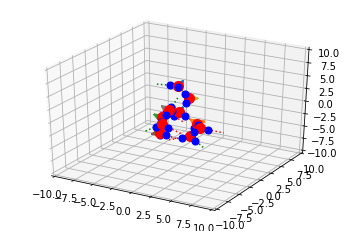

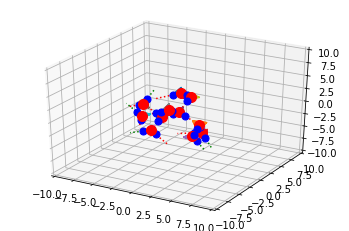

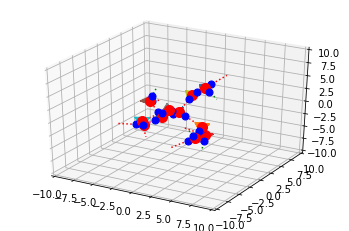

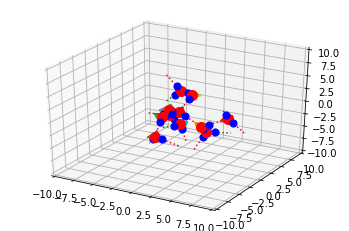

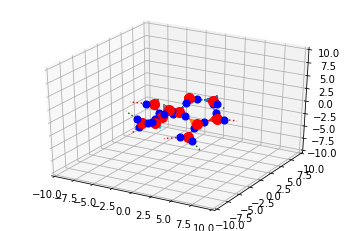

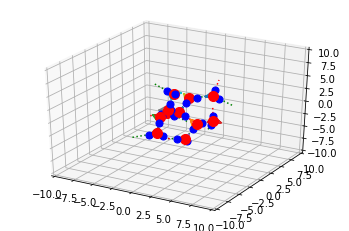

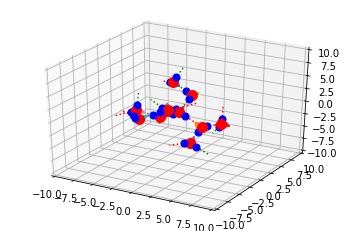

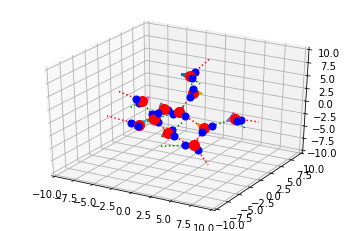

In [4]:
namebase="wernet04a_cluster11_"
r1r2t1t2=[('a',2.75,2.75,0,0), 
          ('b',3.10,2.75,0,0), 
          ('c',3.50,2.75,0,0), 
          ('d', 3.50,2.75,35,0), 
          ('e',2.75,2.75,50,0),
          ('f',2.75,3.00,20,0),
          ('g',3.50,3.00,0,0),
          ('h',3.90,3.90,0,0)
         ]


for ii in range(len(r1r2t1t2)):
    napp,r1,r2,theta1,theta2=r1r2t1t2[ii]
    theta1=deg2rad(theta1)
    theta2=deg2rad(theta2)
    fname=namebase+napp
    
    cluster=fcluster(bond1=r1,bond2=r2,theta1=theta1,theta2=theta2,getcluster=True)
    show()
    
    f= open(fname+".com","w+")
    f.write("%NProcShared=8\n")
    f.write("# SP HF/cc-pVTZ 6D 10F GFInput PUNCH=MO\n")
    f.write("\n")
    f.write("H2O Pentamer "+str(fname)+"\n")
    f.write("\n")
    f.write("0 1\n")
    
    for m in cluster:
        f.write("O %s %s %s\n" % tuple(m.oloc))
        f.write("H %s %s %s\n" % tuple(m.t1))
        f.write("H %s %s %s\n" % tuple(m.t2))
    f.write("\n")
    f.close()
